This code uses the entire >1400-protein *pancancer* dataset to compare 10, 50, 100, 200, and 500 estimators in XGBoost. It incorporates 5-fold k-fold cross-validation.

Running the code with the top 1000, top 500, and top 100 proteins (determined by kbest) provides information on how the number of proteins used affects the ability to reliably distinguish between the different cancer types


In [91]:
import pandas as pd

In [92]:
# Import the data

df_full = pd.read_csv("pancancer.csv")


In [93]:
# Create a pivot table that makes each sample a row, and includes the data for each protein in a column

Pancancer_pivot = df_full.pivot_table(index = ['Sample_ID', 'Cancer'], columns = 'UniProt', values = 'NPX' )
Pancancer_pivot.reset_index(inplace=True)
Pancancer_pivot.head(15)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,AML,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,AML,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,AML,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,AML,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,AML,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960
5,AML_14,AML,0.08920,0.22545,-0.47415,1.83150,0.92420,6.56080,4.30555,0.92640,...,5.56885,2.46510,1.82050,6.14920,5.99445,1.44280,5.41060,0.41685,3.25440,1.09110
6,AML_15,AML,-0.07185,0.10130,-1.39720,3.05240,1.26085,5.36945,1.55795,2.40705,...,1.48585,2.23725,0.15615,2.42300,4.81290,0.49115,2.69765,0.45220,1.49335,1.31605
7,AML_16,AML,0.64490,-0.00030,-1.52450,0.76560,1.11520,1.03430,0.93625,2.18410,...,2.53005,1.27950,-0.38825,0.62780,2.90270,0.30915,1.44680,0.46245,1.34865,0.24400
8,AML_17,AML,0.11200,0.84130,-0.81540,0.51790,2.04955,1.60310,3.77460,-0.22100,...,NaN,NaN,1.16780,NaN,NaN,1.61305,2.62540,0.03750,2.35580,NaN
9,AML_18,AML,0.97170,0.61700,-1.53600,0.22060,1.15250,1.96905,-0.01260,3.56180,...,3.79465,1.84825,0.11195,0.87955,3.94285,-0.40650,1.03135,0.24875,2.67350,1.88915


In [94]:
# Combine all the blood cancers into one category
df_bloodcombined = Pancancer_pivot.copy(deep = True)
#df_bloodcombined=df_bloodcombined.replace(to_replace = ['AML', 'CLL', 'LYMPH', 'MYEL'], value = 'BLOOD' )

In [95]:
# Verify that the groups were combined as expected
set(df_bloodcombined['Cancer'])

{'AML',
 'BRC',
 'CLL',
 'CRC',
 'CVX',
 'ENDC',
 'GLIOM',
 'LUNGC',
 'LYMPH',
 'MYEL',
 'OVC',
 'PRC'}

In [96]:
# Specify the protein list 
proteins=df_bloodcombined.columns[2:]
# Check that we have the right number of proteins
len(proteins)

1463

In [97]:
df_bloodcombined.head()

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,AML,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,AML,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,AML,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,AML,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,AML,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [98]:
# Encode the cancer types as numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_bloodcombined['Cancer'] = le.fit_transform(df_bloodcombined['Cancer'])

In [99]:
df_bloodcombined.head(15)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,0,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,0,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,0,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,0,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,0,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960
5,AML_14,0,0.08920,0.22545,-0.47415,1.83150,0.92420,6.56080,4.30555,0.92640,...,5.56885,2.46510,1.82050,6.14920,5.99445,1.44280,5.41060,0.41685,3.25440,1.09110
6,AML_15,0,-0.07185,0.10130,-1.39720,3.05240,1.26085,5.36945,1.55795,2.40705,...,1.48585,2.23725,0.15615,2.42300,4.81290,0.49115,2.69765,0.45220,1.49335,1.31605
7,AML_16,0,0.64490,-0.00030,-1.52450,0.76560,1.11520,1.03430,0.93625,2.18410,...,2.53005,1.27950,-0.38825,0.62780,2.90270,0.30915,1.44680,0.46245,1.34865,0.24400
8,AML_17,0,0.11200,0.84130,-0.81540,0.51790,2.04955,1.60310,3.77460,-0.22100,...,NaN,NaN,1.16780,NaN,NaN,1.61305,2.62540,0.03750,2.35580,NaN
9,AML_18,0,0.97170,0.61700,-1.53600,0.22060,1.15250,1.96905,-0.01260,3.56180,...,3.79465,1.84825,0.11195,0.87955,3.94285,-0.40650,1.03135,0.24875,2.67350,1.88915


In [100]:
# Split the data into X and y
X = df_bloodcombined[proteins]
y = df_bloodcombined['Cancer']

In [101]:
X.head()

UniProt,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,O00182,O00186,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,1.59230,2.19040,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,1.16670,NaN,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,1.41675,1.16275,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,0.98105,0.65770,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,2.13880,1.47010,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [102]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size=0.2, random_state=100)

In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import sem
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.metrics import geometric_mean_score  # G-Mean

import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
# Initialize models
models = {
    #"Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs')),
    #"k-Nearest Neighbors (n=5)": KNeighborsClassifier(n_neighbors=5), 
    #"k-Nearest Neighbors (n=13)": KNeighborsClassifier(n_neighbors=13),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=100),
    "XGBoost, 10 estimators": XGBClassifier(n_estimators=10),
    "XGBoost, 50 estimators": XGBClassifier(n_estimators=50),
    "XGBoost, 100 estimators": XGBClassifier(n_estimators=100),
    "XGBoost, 200 estimators": XGBClassifier(n_estimators=200),
    "XGBoost, 500 estimators": XGBClassifier(n_estimators=500)
}

In [105]:
# Cross-validation parameters
n_splits = 5  # Number of folds
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

In [106]:
# Initialize KNNImputer for handling missing values
imputer = KNNImputer(n_neighbors=5, weights="uniform")

In [107]:
# Select the top ____ proteins
k_best_features = 1000
selector = SelectKBest(score_func=f_classif, k=k_best_features)


Evaluating XGBoost, 10 estimators with k-fold CV, kNN imputation, and SelectKBest...


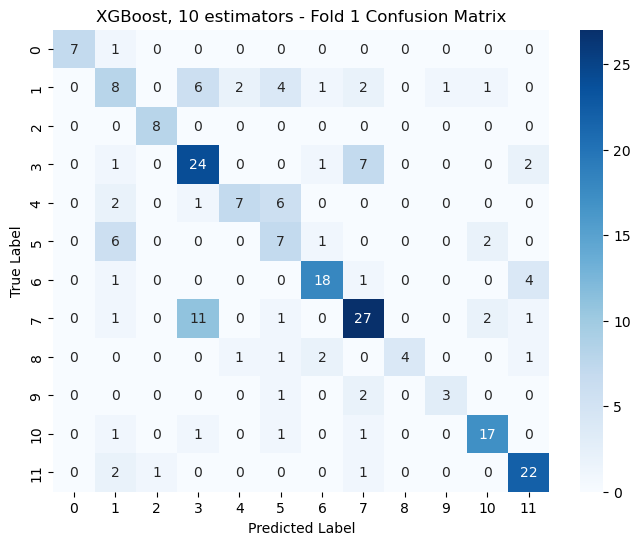


Fold 1 - Accuracy: 0.6414, F1 Score: 0.6402, ROC AUC: 0.9308, G-Mean: 0.7812


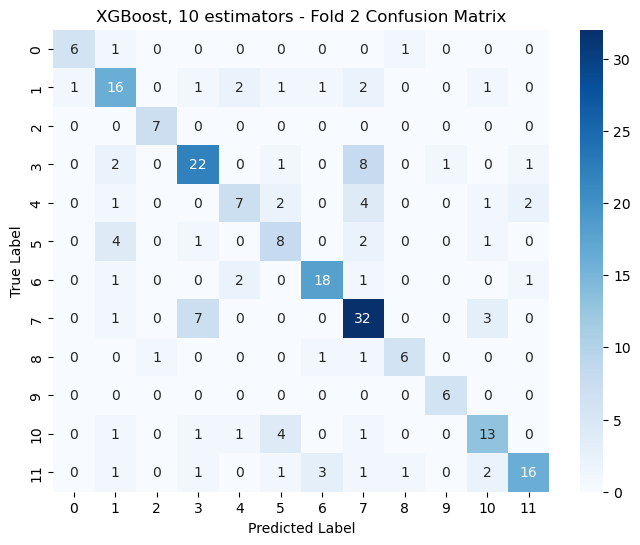


Fold 2 - Accuracy: 0.6653, F1 Score: 0.6635, ROC AUC: 0.9311, G-Mean: 0.7967


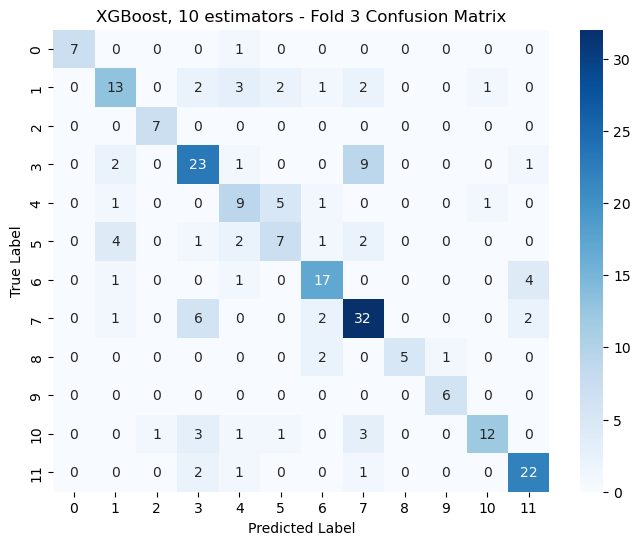


Fold 3 - Accuracy: 0.6780, F1 Score: 0.6764, ROC AUC: 0.9246, G-Mean: 0.8047


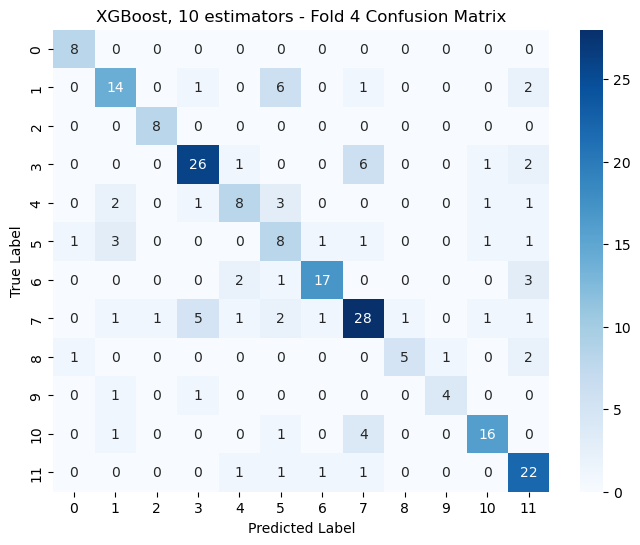


Fold 4 - Accuracy: 0.6949, F1 Score: 0.6961, ROC AUC: 0.9315, G-Mean: 0.8177


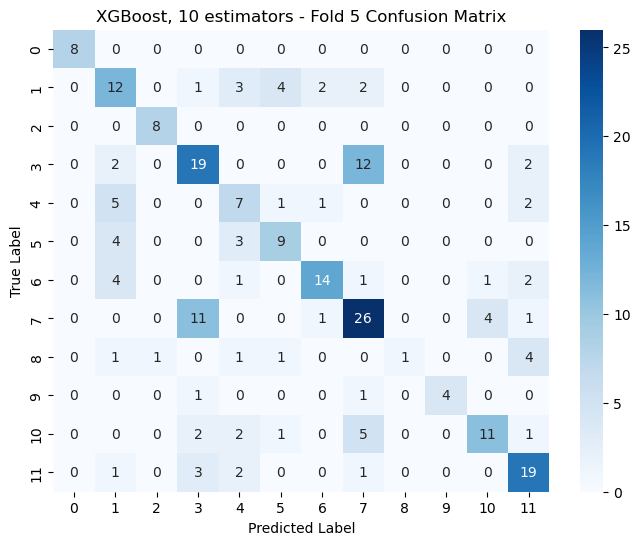


Fold 5 - Accuracy: 0.5847, F1 Score: 0.5814, ROC AUC: 0.8955, G-Mean: 0.7420

XGBoost, 10 estimators - Mean Accuracy: 0.6528 ± 0.0375
XGBoost, 10 estimators - Mean F1 Score: 0.6515 ± 0.0387
XGBoost, 10 estimators - Mean ROC AUC: 0.9227 ± 0.0136
XGBoost, 10 estimators - Mean G-Mean: 0.7884 ± 0.0256

Evaluating XGBoost, 50 estimators with k-fold CV, kNN imputation, and SelectKBest...


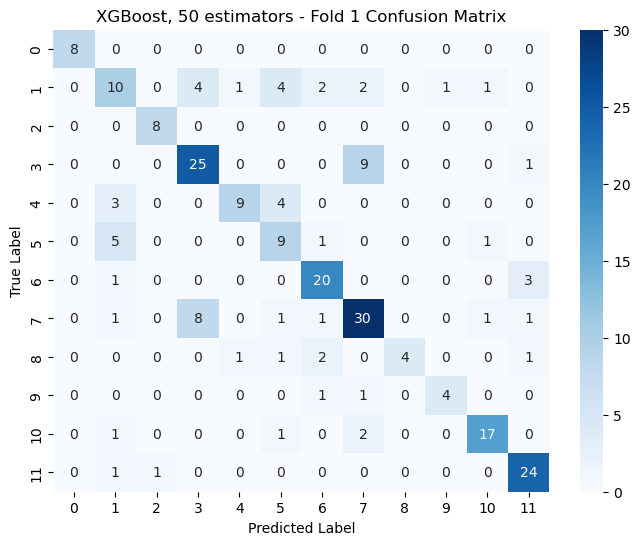


Fold 1 - Accuracy: 0.7089, F1 Score: 0.7056, ROC AUC: 0.9478, G-Mean: 0.8250


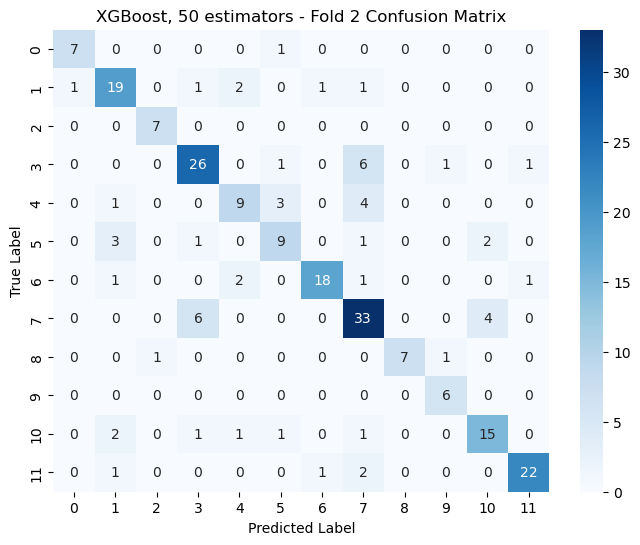


Fold 2 - Accuracy: 0.7542, F1 Score: 0.7541, ROC AUC: 0.9523, G-Mean: 0.8535


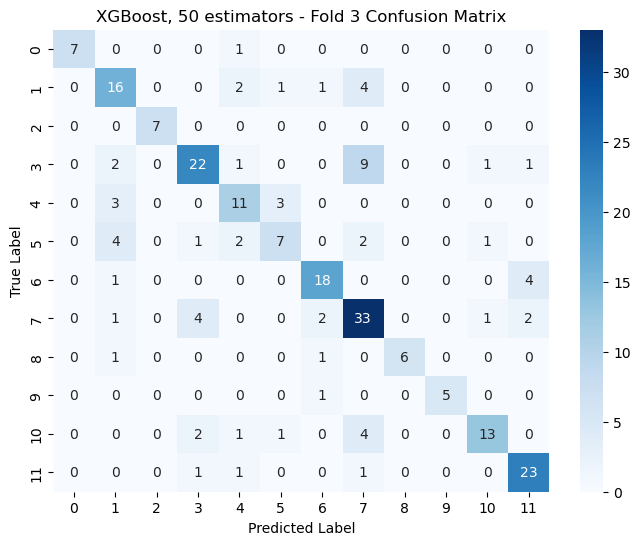


Fold 3 - Accuracy: 0.7119, F1 Score: 0.7111, ROC AUC: 0.9485, G-Mean: 0.8257


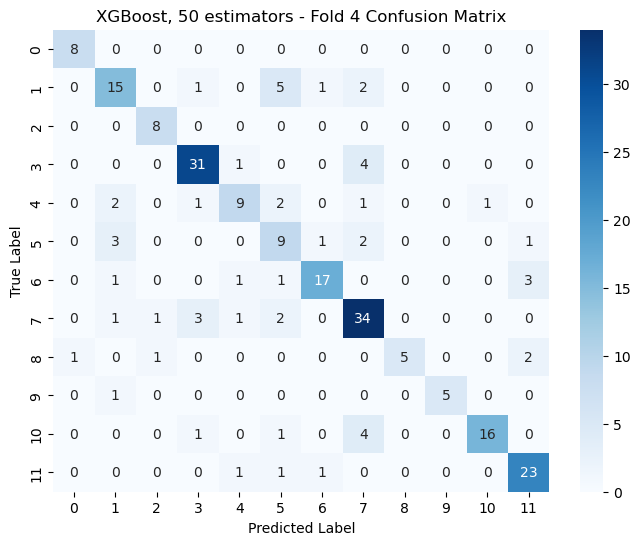


Fold 4 - Accuracy: 0.7627, F1 Score: 0.7636, ROC AUC: 0.9584, G-Mean: 0.8598


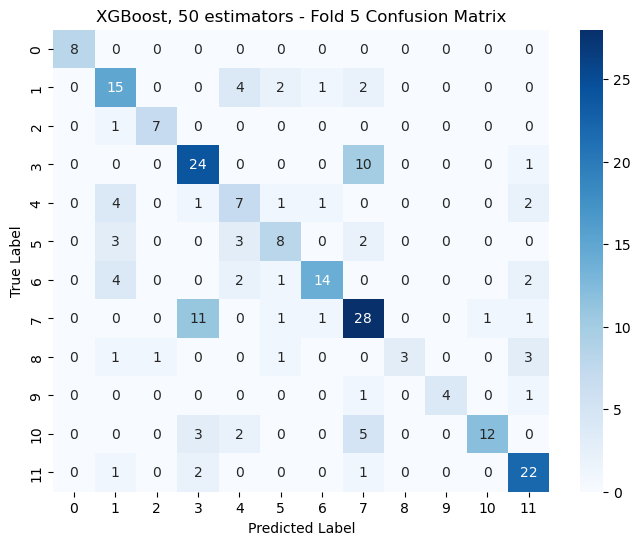


Fold 5 - Accuracy: 0.6441, F1 Score: 0.6449, ROC AUC: 0.9245, G-Mean: 0.7816

XGBoost, 50 estimators - Mean Accuracy: 0.7163 ± 0.0413
XGBoost, 50 estimators - Mean F1 Score: 0.7158 ± 0.0414
XGBoost, 50 estimators - Mean ROC AUC: 0.9463 ± 0.0113
XGBoost, 50 estimators - Mean G-Mean: 0.8291 ± 0.0271

Evaluating XGBoost, 100 estimators with k-fold CV, kNN imputation, and SelectKBest...


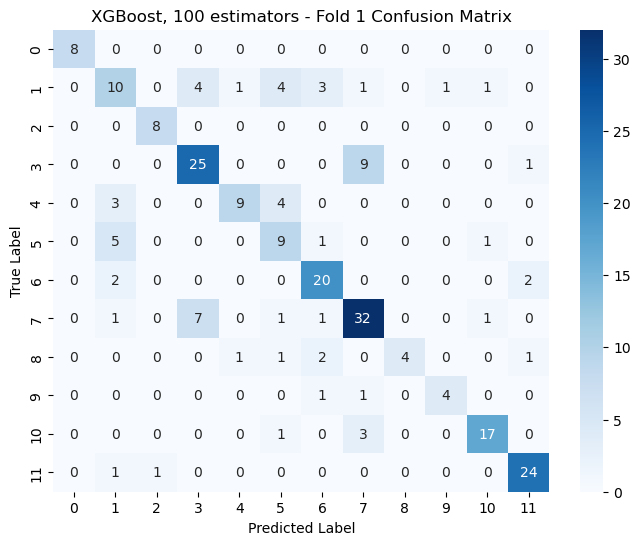


Fold 1 - Accuracy: 0.7173, F1 Score: 0.7143, ROC AUC: 0.9512, G-Mean: 0.8305


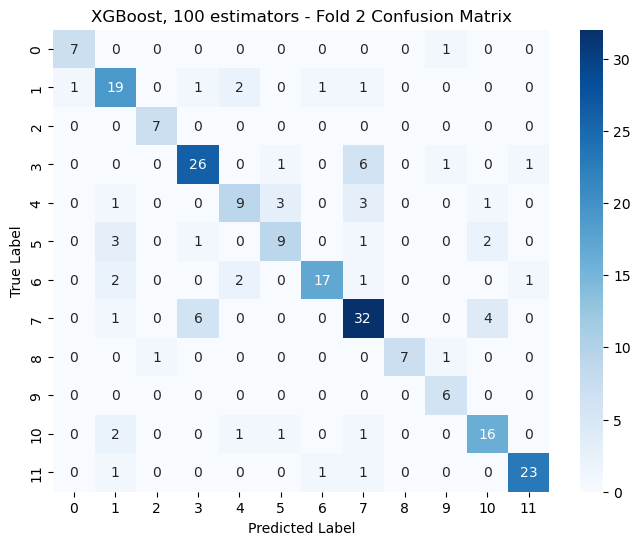


Fold 2 - Accuracy: 0.7542, F1 Score: 0.7539, ROC AUC: 0.9564, G-Mean: 0.8541


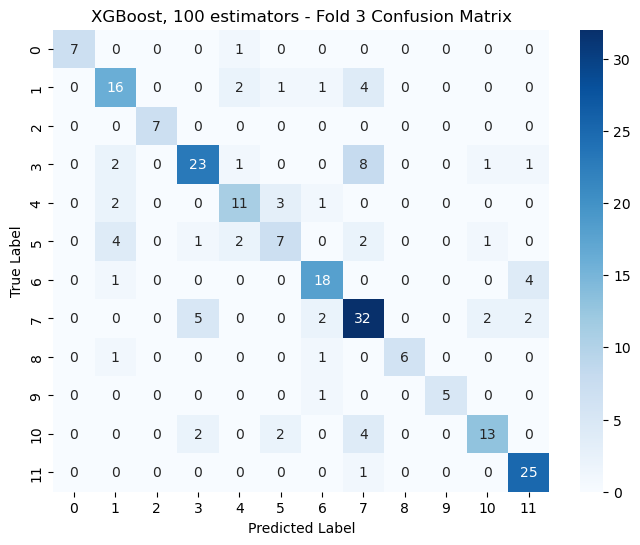


Fold 3 - Accuracy: 0.7203, F1 Score: 0.7181, ROC AUC: 0.9515, G-Mean: 0.8312


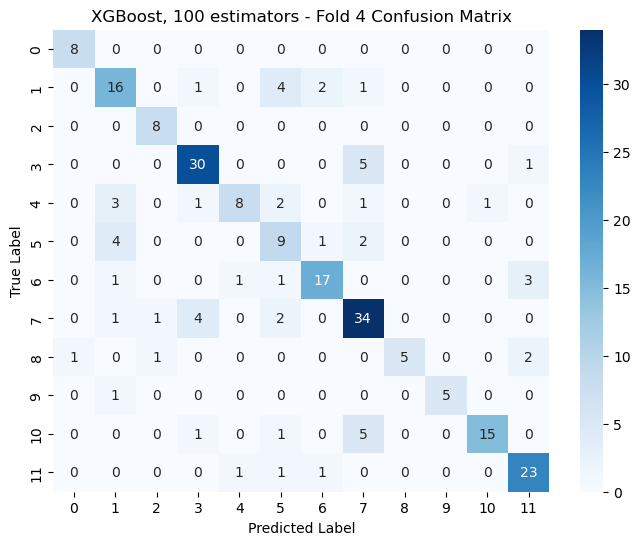


Fold 4 - Accuracy: 0.7542, F1 Score: 0.7540, ROC AUC: 0.9614, G-Mean: 0.8541


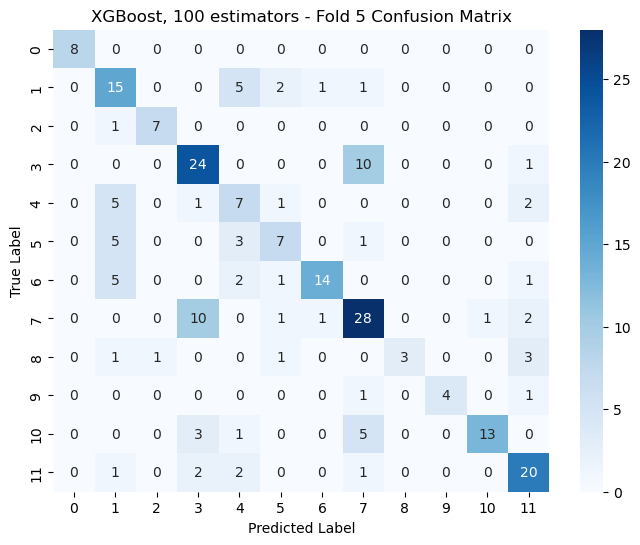


Fold 5 - Accuracy: 0.6356, F1 Score: 0.6399, ROC AUC: 0.9285, G-Mean: 0.7767

XGBoost, 100 estimators - Mean Accuracy: 0.7163 ± 0.0425
XGBoost, 100 estimators - Mean F1 Score: 0.7160 ± 0.0408
XGBoost, 100 estimators - Mean ROC AUC: 0.9498 ± 0.0111
XGBoost, 100 estimators - Mean G-Mean: 0.8293 ± 0.0277

Evaluating XGBoost, 200 estimators with k-fold CV, kNN imputation, and SelectKBest...


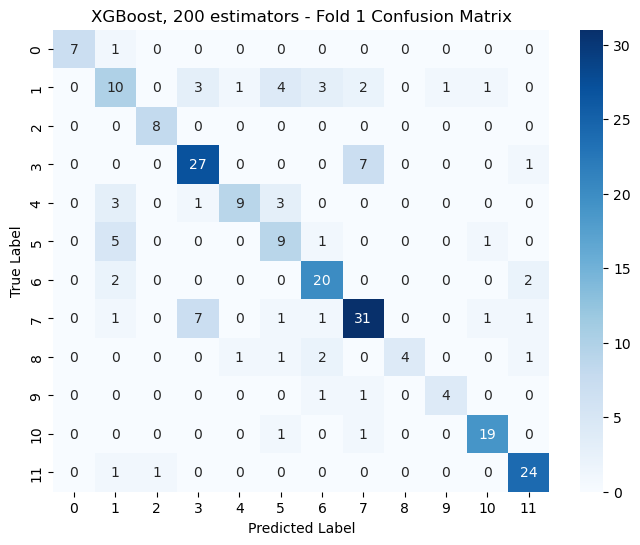


Fold 1 - Accuracy: 0.7257, F1 Score: 0.7223, ROC AUC: 0.9530, G-Mean: 0.8363


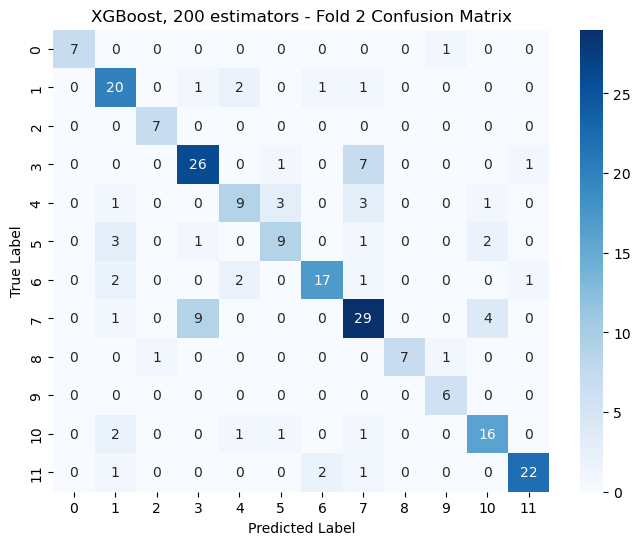


Fold 2 - Accuracy: 0.7415, F1 Score: 0.7413, ROC AUC: 0.9581, G-Mean: 0.8454


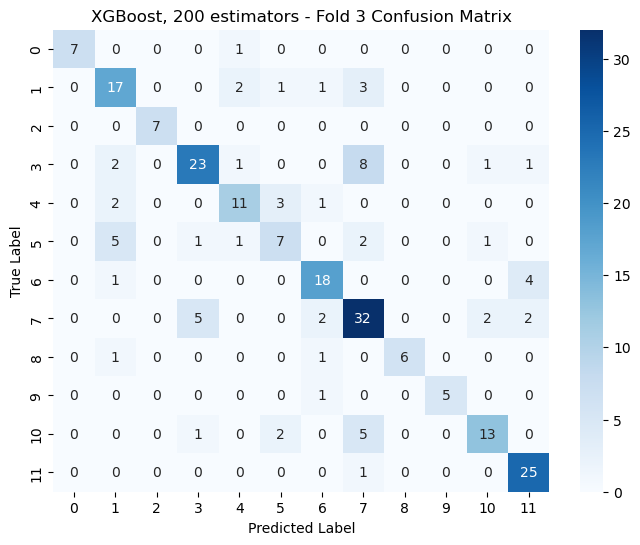


Fold 3 - Accuracy: 0.7246, F1 Score: 0.7225, ROC AUC: 0.9532, G-Mean: 0.8339


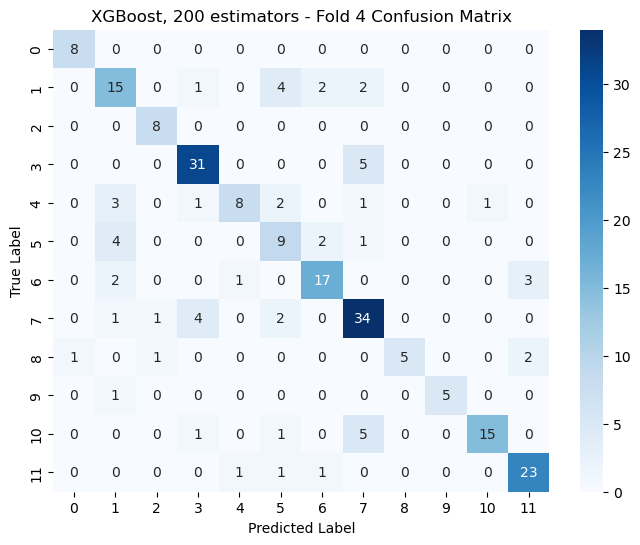


Fold 4 - Accuracy: 0.7542, F1 Score: 0.7533, ROC AUC: 0.9620, G-Mean: 0.8540


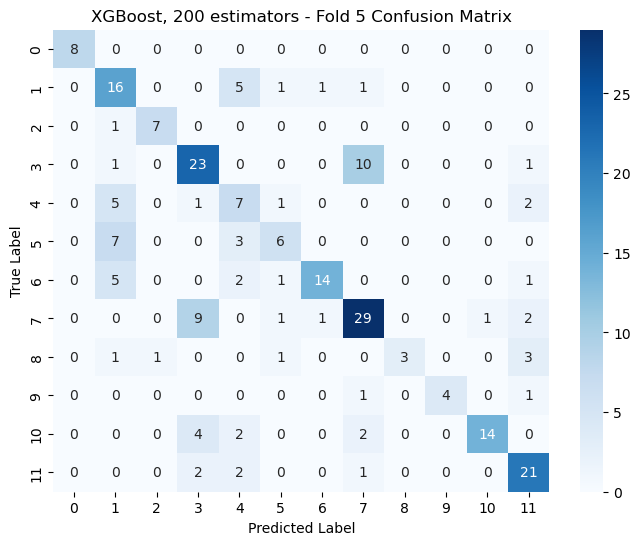


Fold 5 - Accuracy: 0.6441, F1 Score: 0.6483, ROC AUC: 0.9318, G-Mean: 0.7830

XGBoost, 200 estimators - Mean Accuracy: 0.7180 ± 0.0378
XGBoost, 200 estimators - Mean F1 Score: 0.7175 ± 0.0358
XGBoost, 200 estimators - Mean ROC AUC: 0.9516 ± 0.0103
XGBoost, 200 estimators - Mean G-Mean: 0.8305 ± 0.0243

Evaluating XGBoost, 500 estimators with k-fold CV, kNN imputation, and SelectKBest...


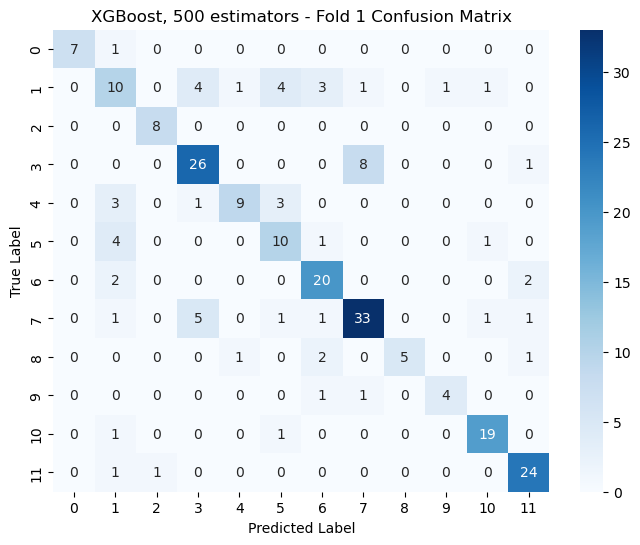


Fold 1 - Accuracy: 0.7384, F1 Score: 0.7357, ROC AUC: 0.9538, G-Mean: 0.8444


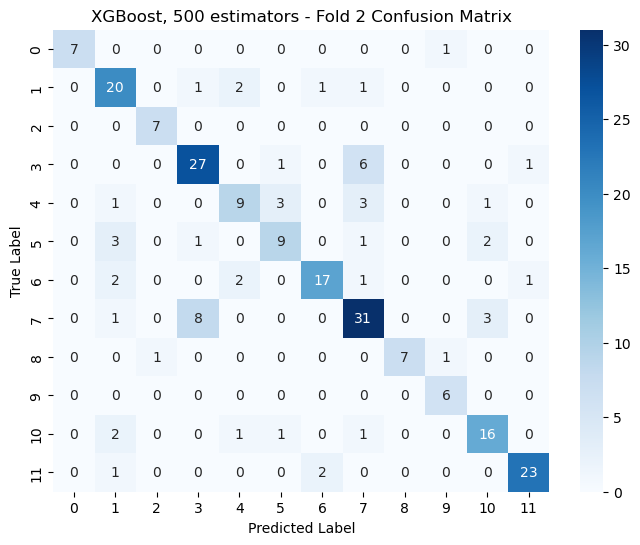


Fold 2 - Accuracy: 0.7585, F1 Score: 0.7578, ROC AUC: 0.9604, G-Mean: 0.8564


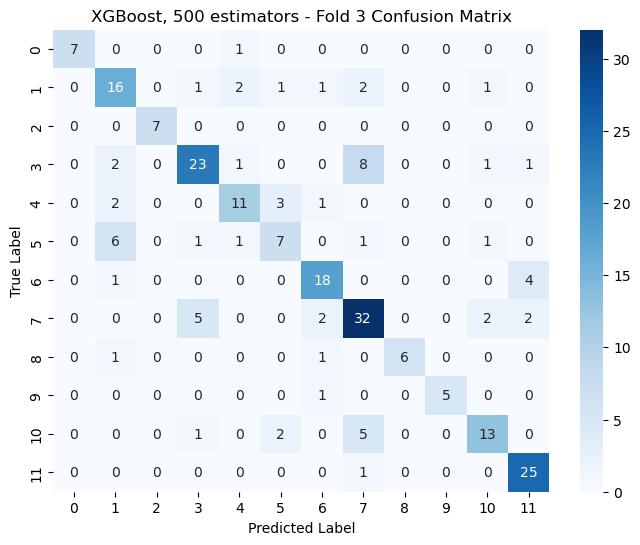


Fold 3 - Accuracy: 0.7203, F1 Score: 0.7181, ROC AUC: 0.9543, G-Mean: 0.8316


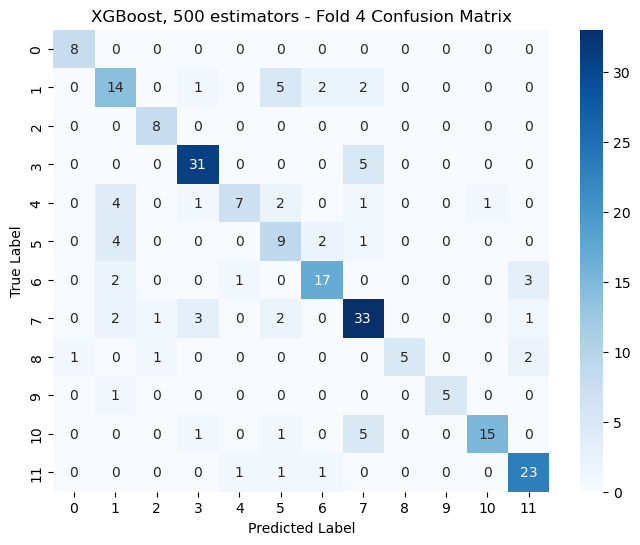


Fold 4 - Accuracy: 0.7415, F1 Score: 0.7410, ROC AUC: 0.9625, G-Mean: 0.8464


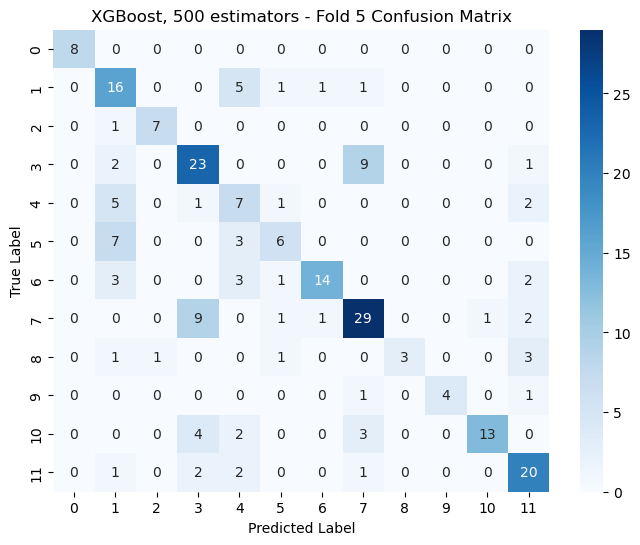


Fold 5 - Accuracy: 0.6356, F1 Score: 0.6406, ROC AUC: 0.9322, G-Mean: 0.7775

XGBoost, 500 estimators - Mean Accuracy: 0.7189 ± 0.0425
XGBoost, 500 estimators - Mean F1 Score: 0.7186 ± 0.0402
XGBoost, 500 estimators - Mean ROC AUC: 0.9527 ± 0.0105
XGBoost, 500 estimators - Mean G-Mean: 0.8312 ± 0.0275


In [108]:
# Loop over models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with k-fold CV, kNN imputation, and SelectKBest...")

    # Containers for metrics across folds
    fold_accuracies = []
    fold_f1_scores = []
    fold_auc_scores = []
    fold_gmeans = []
    fold_confusion_matrices = []

    # k-Fold Cross-Validation Loop
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Extract train and test sets for the current fold
        X_fold_train = X_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_test = y_train.iloc[test_index]

        # Apply KNN Imputer to impute missing values
        X_fold_train_imputed = imputer.fit_transform(X_fold_train)
        X_fold_test_imputed = imputer.transform(X_fold_test)

        # Apply SelectKBest to select top ___ features
        X_fold_train_selected = selector.fit_transform(X_fold_train_imputed, y_fold_train)
        X_fold_test_selected = selector.transform(X_fold_test_imputed)

        # Train the model on the selected features
        clf = model.fit(X_fold_train_selected, y_fold_train)

        # Predict and evaluate metrics on the test fold
        y_pred = clf.predict(X_fold_test_selected)
        fold_accuracy = accuracy_score(y_fold_test, y_pred)
        fold_f1 = f1_score(y_fold_test, y_pred, average='weighted')
        fold_gmean = geometric_mean_score(y_fold_test, y_pred, average='weighted')

        # ROC AUC requires probability estimates for each class
        y_proba = clf.predict_proba(X_fold_test_selected)
        fold_auc = roc_auc_score(y_fold_test, y_proba, multi_class='ovr', average='weighted')

        # Append metrics for this fold
        fold_accuracies.append(fold_accuracy)
        fold_f1_scores.append(fold_f1)
        fold_auc_scores.append(fold_auc)
        fold_gmeans.append(fold_gmean)

        # Calculate and store confusion matrix for this fold
        fold_conf_matrix = confusion_matrix(y_fold_test, y_pred)
        fold_confusion_matrices.append(fold_conf_matrix)

        # Plot the confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(fold_conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f"{model_name} - Fold {i+1} Confusion Matrix")
        plt.show()

        # Print metrics for this fold
        print(f"\nFold {i+1} - Accuracy: {fold_accuracy:.4f}, F1 Score: {fold_f1:.4f}, "
              f"ROC AUC: {fold_auc:.4f}, G-Mean: {fold_gmean:.4f}")

    # Display averaged metrics with 95% confidence intervals
    mean_accuracy = np.mean(fold_accuracies)
    accuracy_confidence_interval = 1.96 * sem(fold_accuracies)

    mean_f1 = np.mean(fold_f1_scores)
    f1_confidence_interval = 1.96 * sem(fold_f1_scores)

    mean_auc = np.mean(fold_auc_scores)
    auc_confidence_interval = 1.96 * sem(fold_auc_scores)

    mean_gmean = np.mean(fold_gmeans)
    gmean_confidence_interval = 1.96 * sem(fold_gmeans)

    print(f"\n{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {accuracy_confidence_interval:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1:.4f} ± {f1_confidence_interval:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_auc:.4f} ± {auc_confidence_interval:.4f}")
    print(f"{model_name} - Mean G-Mean: {mean_gmean:.4f} ± {gmean_confidence_interval:.4f}")
